<a href="https://colab.research.google.com/github/C00ldudeNoonan/Global_inflation_viz/blob/main/Euro_Inflation_Rates_since_2000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

Inflation Data: https://www.worldbank.org/en/research/brief/inflation-database

ShapeFiles: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-boundary-lines/ß

Data needs to be pivoted for Chart (do in excel)
Map Country Codes
Timelapse Plot, This time use gif maker within matplotlib

In [ ]:
!pip install geopandas

In [2]:
from shapely import geometry
from shapely.geometry import Point, Polygon
import pandas as pd
from datetime import datetime
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from geopandas import GeoDataFrame
import imageio
import os
import matplotlib
# test plot
import matplotlib.colors as colors
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


# shapefiles import

CountryBoundaries = '/vsicurl/https://github.com/C00ldudeNoonan/Global_inflation_viz/raw/main/ne_50m_admin_0_countries.shp' 
CountryBoundaries = gpd.read_file(CountryBoundaries)
CountryBoundaries.crs = "EPSG:4326"
CountryBoundaries = CountryBoundaries.to_crs("EPSG:3035") 

mapCountryList = ["Germany", "United Kingdom", "France", "Italy",
                  "Spain", "Ukraine", "Poland", "Romania", "Netherlands",
                  "Belgium", "Czechia", "Greece", "Portugal", "Sweden",
                  "Hungary", "Belarus", "Austria", "Serbia", "Switzerland",
                  "Bulgaria", "Denmark", "Finland", "Slovakia", "Norway",
                  "Ireland", "Croatia", "Moldova", "Bosnia and Herzegovina",
                  "Albania", "Lithuania", "North Macedonia", "Slovenia",
                  "Latvia", "Estonia", "Montenegro", "Luxembourg", "Malta", 
                  "Iceland", "Turkey", "Egypt", "Jordan", "Syria", "Israel",
                  "Cyprus", "Algeria", "Morocco", "Libya", "Tunisia", "Russia"
                  ,"Georgia", "Lebanon", 'North Cyprus', "Republic of Serbia",
                  "Kosovo"
                  ]

euro_df = CountryBoundaries[CountryBoundaries['SOVEREIGNT'].isin(mapCountryList)]
fig  = plt.figure(constrained_layout=False, figsize=(60, 20))
ax = fig.add_subplot()
aoi_bounds = euro_df[euro_df['SOVEREIGNT']=='Germany'].geometry.total_bounds
print(aoi_bounds)
plot_bounds = [aoi_bounds[0]-1800000, aoi_bounds[1]+4200000, aoi_bounds[2]-4000000, aoi_bounds[3]+2000000 ]
ax.set_xlim([plot_bounds[0], plot_bounds[1]])
ax.set_ylim([plot_bounds[2], plot_bounds[3]])

euro_df.boundary.plot(ax=ax, color='black', linewidth=1 )
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['Aruba', 'Afghanistan', 'Angola', 'Albania', 'United Arab Emirates', 'Argentina', 'Armenia', 'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Botswana', 'Central African Republic', 'Canada', 'Switzerland', 'Chile', 'China', "CÃ´te d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cayman Islands', 'Cyprus', 'Czech Republic', 'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egypt, Arab Rep.', 'Spain', 'Estonia', 'Ethiopia', 'Finland', 'Fiji', 'France', 'Micronesia, Fed. Sts.', 'Gabon', 'United Kingdom', 'Georgia', 'Ghana', 'Guinea', 'Gambia, The', 'Guinea-Bissau', 'Equatorial Guinea', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hong Kong SAR, China', 'Honduras', 'Croatia

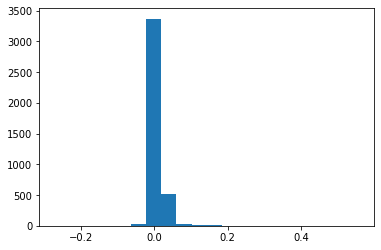

In [4]:
# csv transformation
# subset Euro Countries (Turkey too)

HeadlineInfaltionQuarterly = pd.read_csv("https://raw.githubusercontent.com/C00ldudeNoonan/Global_inflation_viz/main/Headline_inflation_quarterly.csv")

HeadlineInfaltionSubset = HeadlineInfaltionQuarterly[HeadlineInfaltionQuarterly['Country'].isin(mapCountryList)]
numCols = [int(col) for col in HeadlineInfaltionSubset if col.startswith('2')]

for col in numCols:
  index = numCols.index(col)
  if col== numCols[-1]:
    pass
  else:
    HeadlineInfaltionSubset[str(numCols[index+1])+"_pct_change"] = (HeadlineInfaltionSubset[str(numCols[index+1])] - HeadlineInfaltionSubset[str(numCols[index])])/HeadlineInfaltionSubset[str(numCols[index])]

# getting all columns for wide to long pivot
filter_col = [col for col in HeadlineInfaltionSubset if col.endswith('_pct_change') or col =='Country']

HeadlineInfaltionSubset = HeadlineInfaltionSubset[filter_col]
HeadlineInfaltionPivot = pd.melt(HeadlineInfaltionSubset
                                 ,id_vars=["Country"]
                                 ,value_vars=[col for col in HeadlineInfaltionSubset if col.startswith('2')]
                                 ,var_name='Quarter'
                                 ,value_name='HeadlineInflation')
HeadlineInfaltionPivot["Quarter"] = HeadlineInfaltionPivot["Quarter"].apply(lambda x: x.replace("_pct_change", ""))
HeadlineInfaltionPivot = HeadlineInfaltionPivot.astype({"Quarter": int, "HeadlineInflation": float})

print(list(HeadlineInfaltionQuarterly['Country'].unique()))
# replace country value 'Czech Republic':'Czechia', 'Russian Federation': 'Russia', 'Egypt, Arab Rep.':'Egypt'
HeadlineInfaltionPivot["Country"] = HeadlineInfaltionPivot["Country"].apply(lambda x: x.replace("Czech Republic", "Czechia"))
HeadlineInfaltionPivot["Country"] = HeadlineInfaltionPivot["Country"].apply(lambda x: x.replace("Russian Federation", "Russia"))
HeadlineInfaltionPivot["Country"] = HeadlineInfaltionPivot["Country"].apply(lambda x: x.replace("Egypt, Arab Rep.", "Egypt"))

print(HeadlineInfaltionPivot.head())
# % change calculation between columns loop on filtercolumn list
plt.hist(HeadlineInfaltionPivot['HeadlineInflation'], bins=20)
plt.show()


In [7]:



def plot_frame(period):
  
  # subsetting and merging data frames
  plotdf = HeadlineInfaltionPivot[HeadlineInfaltionPivot['Quarter']==period]
  plotdf = euro_df.merge(plotdf, how='left', right_on='Country',left_on='SOVEREIGNT')
  plotdf = GeoDataFrame(plotdf)

  fig  = plt.figure(constrained_layout=False, figsize=(30, 15))
  ax = plt.axes()

  # COLOR SCALES
  cmap = matplotlib.colors.ListedColormap(['#577590', '#4d908e', '#43aa8b'
                                            , '#90be6d', '#f9c74f', '#f9844a'
                                            ,'#f8961e','#f3722c'])
  bounds = np.array([-0.4,-0.04, -0.02, 0, 0.02, 0.04, 0.1, 0.4])
  norm = colors.BoundaryNorm(boundaries=bounds, ncolors=7)

  # plot bounds centered on Europe
  aoi_bounds = euro_df[euro_df['SOVEREIGNT']=='Germany'].geometry.total_bounds
  plot_bounds = [aoi_bounds[0]-1800000, aoi_bounds[1]+4200000, aoi_bounds[2]-4000000, aoi_bounds[3]+2000000 ]
  
  ax.set_xlim([plot_bounds[0], plot_bounds[1]])
  ax.set_ylim([plot_bounds[2], plot_bounds[3]])

  ax.set_title('Inflation By Country : ' + str(period)[:-1] + "-Q"+ str(period)[-1], fontsize=26, weight='bold', color="Black")
  plotdf.plot(ax=ax
              , column='HeadlineInflation'
              , cmap=cmap
              , edgecolor="black"
              , norm=norm
              , legend=True
              ,missing_kwds={"color": "lightgrey",
                             "edgecolor": "red",
                             "hatch": "///",
                             "label": "Missing values",
              },)
  
  #save image
  filename = str(period) + ".png"
  ax.axis('off')
  plt.savefig(filename, bbox_inches='tight', facecolor='#8ecae6')
  plt.close()
  #plt.show()
  return filename



'20081.png'

In [6]:
%%time
filenames = []

# loop through and saving gifs for each period
for period in list(HeadlineInfaltionPivot["Quarter"].unique()):
  filenames.append(plot_frame(period))

# build gif
with imageio.get_writer('Inflation_timelapse.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        imageframe2 = image
        writer.append_data(image)
        writer.append_data(imageframe2)

# Remove files
for filename in set(filenames):
    os.remove(filename)

CPU times: user 1min 21s, sys: 9.5 s, total: 1min 31s
Wall time: 1min 23s
